# Simple Neural Network With Numpy Lab

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from google.colab import files

In [24]:
!cp /content/drive/MyDrive/Datasets/lab_coffee_utils.py /content

In [25]:
!cp /content/drive/MyDrive/Datasets/lab_utils_common.py /content

In [26]:
!cp /content/drive/MyDrive/Datasets/deeplearning.mplstyle /content

In [47]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from lab_utils_common import dlc, sigmoid
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

### Dataset
This is the cofee data set.

In [28]:
X,Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


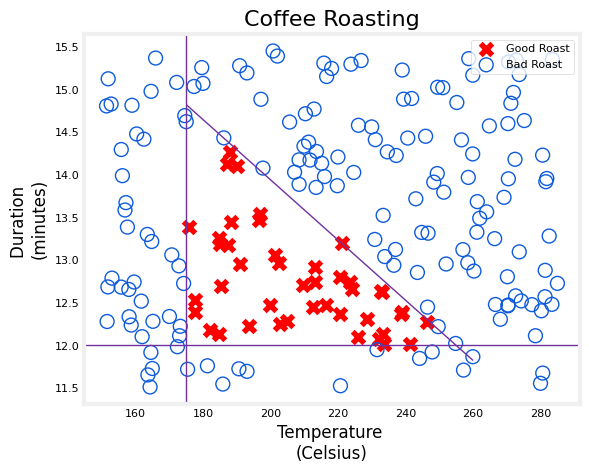

In [29]:
# Plotting coffee data
plt_roast(X,Y)

## Normalising Data

In [30]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


## Numpy Model (Forward Prop in NumPy)
In the first optional lab, we constructed a neuron in NumPy and in Tensorflow and noted their similarity. A layer simply contains multiple neurons/units. As described in lecture, one can utilize a for loop to visit each unit (`j`) in the layer and perform the dot product of the weights for that unit (`W[:,j]`) and sum the bias for the unit (`b[j]`) to form `z`. An activation function `g(z)` can then be applied to that result. <br>
Now we try that below to build a "dense layer" subroutine.

First, we will define the activation function `g()`. We will use the `sigmoid()` function which is already implemented for in the `lab_utils_common.py`.

In [48]:
# Defining the activation function

g = sigmoid

Now we will define the `my_dense()` function which computes the activations of a dense layer.

In [49]:
def my_dense(a_in, W, b):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units
    Returns
      a_out (ndarray (j,))  : j units|
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):
        w = W[:,j]
        z = np.dot(w, a_in) + b[j]
        a_out[j] = g(z)
    return(a_out)

The following cell builds a two-layer neural network utilizing the `my_dense` subroutine above.

In [40]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x,  W1, b1)
    a2 = my_dense(a1, W2, b2)
    return(a2)

In [50]:
#trained weights and biases from
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

## Predictions
Once we have a trained model, you can then use it to make predictions. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Now we start by writing a routine similar to Tensorflow's `model.predict()`. This will take a matrix $X$ with all $m$ examples in the rows and make a prediction by running the model.

In [52]:
def my_predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2)
    return(p)

In [53]:
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_tstn = norm_l(X_tst)  # remember to normalize
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

<ipython-input-52-0b79d0e70caf>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = my_sequential(X[i], W1, b1, W2, b2)


To convert the probabilities to a decision, we apply a threshold:

In [54]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished as following too:

In [55]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Network Function
This graph shows the operation of the whole network.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  

<ipython-input-52-0b79d0e70caf>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = my_sequential(X[i], W1, b1, W2, b2)


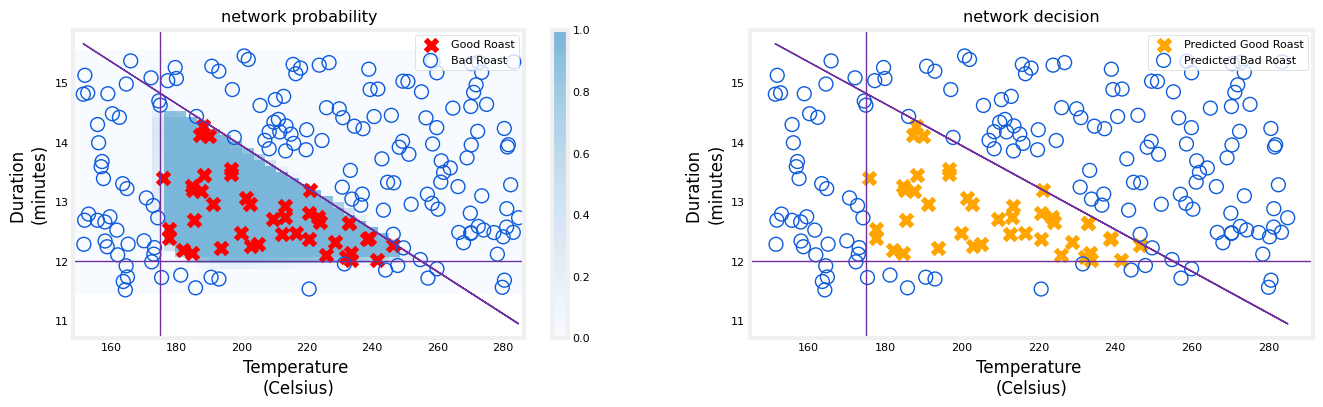

In [56]:
netf= lambda x : my_predict(norm_l(x),W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X,Y,netf)